# Next Best Action Model

This is a tutorial on building a strategic next best action model using reinforcement leanring (fitted Q iteration).

| Description | D002 (see [descriptions](https://github.com/ikatsov/tensor-house/blob/master/resources/descriptions.md)) |
|--|:--|
| Dataset | Generated internally, no external dependencies |
| Papers | Theocharous2015, Riedmiller2005 (see [papers](https://github.com/ikatsov/tensor-house/blob/master/resources/papers.md)) | 
| Installation | NA |
| Libs | Scikit-learn, Numpy |

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from sklearn.ensemble import RandomForestRegressor
from sklearn.manifold import TSNE

# Setting the parameters needed to export figures as PDFs 
# plt.rcParams.update({'font.size': 14, 'pdf.fonttype': 'truetype', 
#                     'font.family':'Candara', 'font.serif':['Candara']})

## Environment parameters

In [2]:
events = [
    0, # no action
    1, # visit
    2  # purchase
]
offers = [
    1, # advertisement
    2, # small disocunt
    3  # large discount
]
demogr = [
    0, # low sensitivity
    1  # high sensitivity
]

n = 1000 # users
k = 100  # time intervals
m = 3    # offers

## Auxiliary functions

In [3]:
def multinomial_int(p):
    return np.where(np.random.multinomial(1, p) == 1)[0][0]

def count(ndarray, val):
    return np.count_nonzero(ndarray == val)

def index(ndarray, val, default):
    try:
        return ndarray.tolist().index(val)
    except:
        return default

    
def find_offer_times(f):
    # return first non zero element in f     
    return np.nonzero(f)[0]

def offer_seq(f):
    # return all strictly postive elements in f
    return f[np.where(f > 0)]

In [3]:
# Environment simulator

# Here we create some plausible but arbitrary rules governing a customer behavior

In [3]:
def get_event_pr(d, f):
    #  d: demographic feature 
    #  f: list of offers received up to this point 
    #     
    f_ids = offer_seq(f) 
    f_ids = np.concatenate((f_ids, np.zeros(3 - len(f_ids))))
    
    if((f_ids[0] == 1 and f_ids[1] == 3) or 
       (f_ids[1] == 1 and f_ids[2] == 3) or 
       (f_ids[0] == 1 and f_ids[2] == 3)): 
            # higher probability of a purchase
            p_events = [0.70, 0.08, 0.22]     
    else:
        # default probability distribution over events
        p_events = [0.90, 0.08, 0.02]         
    # add some noise
    if(np.random.binomial(1, 0.1) > 0):       
        p_events = [0.70, 0.08, 0.22]
    
    return p_events

In [28]:
def generate_profiles(n, k, m):
    # n: number of users
    # k: number of time steps
    # m: max number of offer made
    # offer probabilities (behavioral policy)
    p_offers = [1 / m] * m                                
    # offer campaing times
    t_offers = np.linspace(0, k, m + 2).tolist()[1 : -1]      
    # offer time jitter, standard deviation in time units 
    t_offer_jit = 5       

    # Matrices initialization     
    # matrix of profile events
    P = np.zeros((n, k))   
    # offer history
    F = np.zeros((n, k))
    # demographic features
    D = np.zeros((n, 1))                                      
    # for each user     
    for u in range(0, n):
        # get the demographic feature: low (0) or high (1) sensitivity          
        D[u, 0] = np.random.binomial(1, 0.5)
    
        # determine m time points to issue offers for customer u
        # add the a random jitter to the offer times and round to nearest integer
        offer_times_u = np.rint(t_offer_jit * np.random.randn(len(t_offers)) + t_offers)

        # simulate a trajectory for customer u
        # for each time interval         
        for t in range(0, k):
            # if it is the chosen time for an offer for this customer
            if t in offer_times_u:
                # issue an offer at time t according to the behavioral policy
                # in this case an integer between 1 and m
                F[u, t] =  multinomial_int(p_offers) + 1
            # simulate an event at time t
            event = multinomial_int(get_event_pr(D[u], F[u]))   
            # add event to P             
            P[u, t] = event
    return P, F, D

In [34]:
def visualize_profiles(m, title=None):
    fig, ax = plt.subplots(figsize=(10, 20))
    chart = ax.imshow(m, cmap='viridis', interpolation='none')
    ax.set_aspect(0.5 * m.shape[1] / m.shape[0])
    ax.grid(False)
    ax.set_xlabel('Time')
    ax.set_ylabel('User ID')
    plt.colorbar(chart, fraction=0.025, pad=0.04, ax=ax)
    if title:
        ax.set_title(title)
    plt.show() 

In [30]:
# training set
P, F, D = generate_profiles(n, k, m)

In [31]:
# test set
Pt, Ft, Dt = generate_profiles(n, k, m)

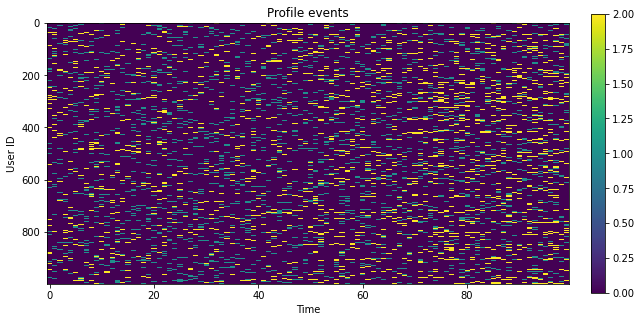

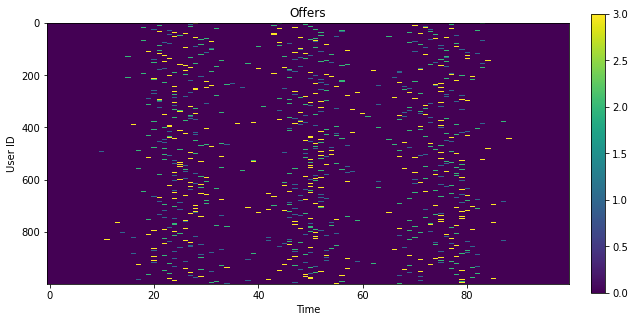

In [35]:
visualize_profiles(P, title="Profile events")
visualize_profiles(F, title="Offers")

In [ ]:
#
# Cut trajectories into transitions
#
def state_features(p, f, d, t_start, t_end):
    p_frame = p[0:t_end]
    f_frame = f[0:t_end]
    f1 = index(f_frame, 1, k)  
    f2 = index(f_frame, 2, k)
    f3 = index(f_frame, 3, k)
    return np.array([
        d[0],                  # demographic features
        count(p_frame, 1),     # number of visits
        f1,                    # first time offer 1 was issued
        f2,                    # first time offer 2 was issued
        f3                     # first time offer 3 was issued
    ])

def frame_reward(p, t_start, t_end):
    return count(p[t_start:t_end], 2)   # number of purchases in the time frame

def offer_time_ranges(times):
    rng = [-1] + times + [k]
    return list(zip(map(lambda x: x + 1, rng), rng[1:]))
    
def prepare_trajectories(P, F, D):
    T = []
    for u in range(0, n):
        offer_times = find_offer_times(F[u]).tolist()
        ranges = offer_time_ranges(offer_times)
        
        T_u = []
        for r in range(0, len(ranges)):
            (t_start, t_end) = ranges[r]
            state = state_features(P[u], F[u], D[u], 0, t_start)
            reward = frame_reward(P[u], t_start, t_end)
            state_new = state_features(P[u], F[u], D[u], t_start, min(t_end + 1, k))
            is_end_of_trajectory = t_end >= k
            
            if(t_end in offer_times): 
                action = F[u, t_end]
            else:
                action = 1 # default action
                
            T_u.append([state, action, reward, state_new, is_end_of_trajectory])
            
        T.append(T_u) 
        
    return np.array(T)

T = prepare_trajectories(P, F, D)
Tt = prepare_trajectories(Pt, Ft, Dt)

## Policy Learning

In [163]:
#
# Find the optimal action under a greedy policy and corresponding state value
#
def best_action(Q, state, actions):
    v_best = 0
    a_best = 0
    for a in actions:
        v = Q([np.append(state, a)])[0]
        if(v > v_best):
            v_best = v
            a_best = a
            
    return a_best, v_best

def Q_0(sa):
    return [1]

Q = Q_0
for i in range(1, 5): # FQI iterations
    X = []
    Y = []
    for sample in T.reshape((n * (m + 1), -1)):
        state, action, reward, state_new, is_end_of_trajectory = sample
        x = np.append(state, action) # feature vector consists of state-action pairs
    
        a_best, v_best = best_action(Q, state_new, offers)
        
        y = reward + v_best    # we ignore the initial conditions (ends of trajectories) for the sake of illustration      
    
        X.append(x)
        Y.append(y)
    
    regr = RandomForestRegressor(max_depth=4, random_state=0, n_estimators=10)
    regr.fit(X, np.ravel(Y))    
    Q = regr.predict

In [164]:
# Values of possible actions for a user who did not get any offer yet  
print(Q([[0, 0, 100, 100, 100, 1]]))
print(Q([[0, 0, 100, 100, 100, 2]]))
print(Q([[0, 0, 100, 100, 100, 3]]))

# Values of possible actions for a user who got offer #1 at time step 20  
print(Q([[0, 0, 20, 100, 100, 1]]))
print(Q([[0, 0, 20, 100, 100, 2]]))
print(Q([[0, 0, 20, 100, 100, 3]]))

[13.61321886]
[5.82460587]
[5.82460587]
[13.93350275]
[13.93350275]
[18.20843831]


In [165]:
#
# Use the test set to evaluate the policy
#
states = Tt[:, :, 0].flatten().tolist()

values = []
best_actions = []
for s in states:
    a_best, v_best = best_action(Q, s, offers)
    values.append(v_best)
    best_actions.append(a_best)
    
s_tsne = TSNE(learning_rate = 100).fit_transform(states)

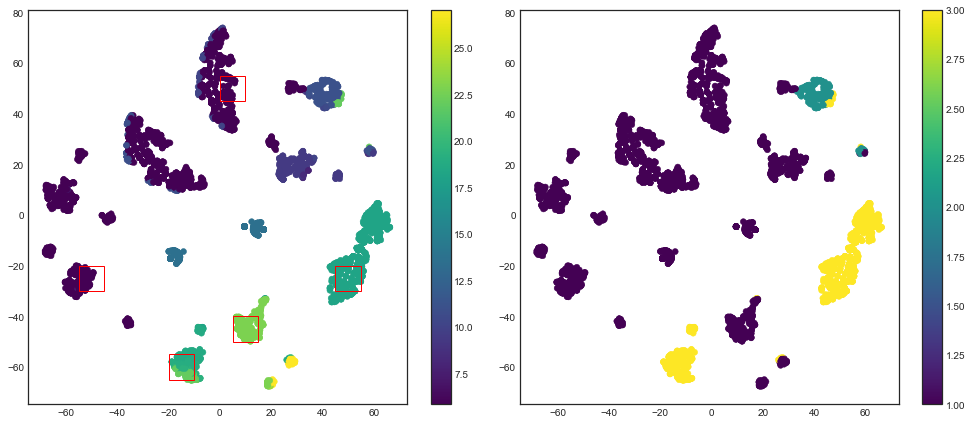

Segment ((-55, -45), (-30, -20)):
 [[100.  29.  48.]
 [100.  29.  48.]
 [100.  26.  51.]
 [100.  26.  51.]
 [100.  38.  52.]]
Segment ((45, 55), (-30, -20)):
 [[ 20. 100. 100.]
 [ 20. 100. 100.]
 [ 20. 100. 100.]
 [ 21. 100. 100.]
 [ 20. 100. 100.]]
Segment ((-20, -10), (-65, -55)):
 [[ 31.  54. 100.]
 [ 31.  54. 100.]
 [ 28.  52. 100.]
 [ 20.  43. 100.]
 [ 20.  43. 100.]]
Segment ((0, 10), (45, 55)):
 [[100. 100.  25.]
 [100. 100.  25.]
 [100. 100.  25.]
 [100. 100.  26.]
 [100. 100.  26.]]
Segment ((5, 15), (-50, -40)):
 [[ 27. 100.  54.]
 [ 27. 100.  54.]
 [ 21. 100.  42.]
 [ 21. 100.  42.]
 [ 14. 100.  49.]]


In [172]:
#
# Visualuze the Q-values and best action for individual users
#

#
# Segment boxes need to be set manually because the tSNE
# projection changes unpredictabley as the data changes  
#
segments = [
    ( (-55, -45), (-30, -20) ),
    ( (45, 55),   (-30, -20) ),
    ( (-20, -10), (-65, -55) ),
    ( (0, 10),    (45, 55) ),
    ( (5, 15),    (-50, -40) )
]

fig, ax = plt.subplots(1, 2, figsize=(14, 6))
scatter = ax[0].scatter(s_tsne[:, 0], s_tsne[:, 1], c=values, cmap='viridis')
plt.colorbar(mappable=scatter, ax=ax[0])
for s in segments:
    rect = Rectangle((s[0][0], s[1][0]), s[0][1] - s[0][0], s[1][1] - s[1][0], linewidth=1, edgecolor='r', facecolor='none')
    ax[0].add_patch(rect)


scatter = ax[1].scatter(s_tsne[:, 0], s_tsne[:, 1], c=best_actions, cmap='viridis')
plt.colorbar(mappable=scatter, ax=ax[1])
plt.tight_layout()
plt.show()


for s in segments:
    segment = ((s_tsne[:, 0] > s[0][0]) & (s_tsne[:, 0] < s[0][1]) & (s_tsne[:, 1] > s[1][0]) & (s_tsne[:, 1] < s[1][1]))
    print(f'Segment {s}:\n', np.array(states)[segment, 2:][:5])

# Policy Evaluation

FQI provides a way to learn the Q function and derive some policy (e.g. epsilon-greedy) from it. 
If we change the policy, we need to evaluate its performance. It can be done using historical trajectories.

In [173]:
def make_epsilon_greedy_policy(Q, eps):
    def egreedy_policy(state, action):
        a_best, v_best = best_action(Q, state, offers)

        if(a_best == action):
            return 1 - eps
        else:
            return eps / (m - 1)
        
    return egreedy_policy


# Probability of action given state
def behavioral_policy(state, action):
    return 1 / m

# Estimates the target policy return based on 
# the profiles (trajectories) P generated under the behavioral policy 
def evaluate_policy_return(T, behavioral_policy, target_policy):
    returns = []
    for trajectory in T:                                                   
        importance_weight = 1
        trajectory_reward = 0
        for transition in trajectory:            
            state, action, reward  = transition[0:3]
            action_prob_b = behavioral_policy(state, action)
            action_prob_t = target_policy(state, action)
            
            importance_weight *= (action_prob_t / action_prob_b) 
            trajectory_reward += reward
            
        returns.append(trajectory_reward * importance_weight)
        
    return np.mean(returns)   

In [174]:
policy_returns = []
eps = np.linspace(0, 2/3, num = 10)
for e in eps:
    policy = make_epsilon_greedy_policy(Q, e)
    policy_returns.append( evaluate_policy_return(T, behavioral_policy, policy) )

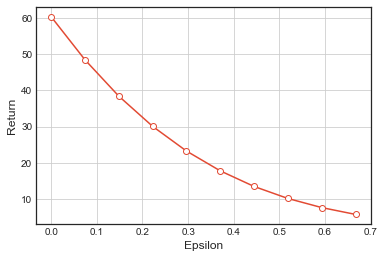

In [137]:
plt.style.use('seaborn-white')
plt.grid(True)
plt.xlabel('Epsilon')
plt.ylabel('Return')
plt.plot(eps, policy_returns, '-o', mfc='w')
plt.show()